In [1]:
import numpy as np
import pandas as pd
#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
%matplotlib inline

In [2]:
#load data
df_train = pd.read_csv("./train.csv")
y = df_train.Survived
X = df_train.drop(["Survived"], axis=1)

# Exploring data

In [15]:
X.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


Try to fill missing values in Age and Embarked, Delete Cabin, PassengerID and Ticket columns

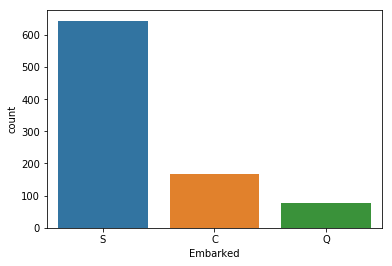

In [8]:
sns.countplot(x="Embarked", data=X)

In [9]:
#Use the mode to fill missin val in Embarked column
X.Embarked.mode()

0    S
dtype: object

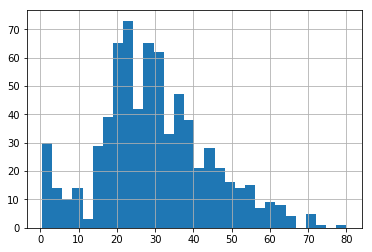

In [20]:
X.Age.hist(bins=30)

In [11]:
X.Age.mean()

29.69911764705882

In [12]:
X.Age.median()

28.0

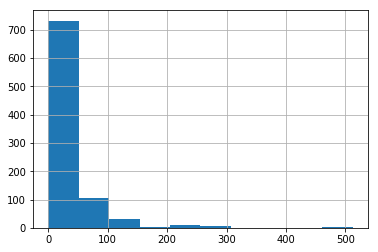

In [13]:
X.Fare.hist()

# Feature Engineering

In [77]:
titleDict = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Sir",
    "Don": "Sir",
    "Sir": "Sir",
    "Dr": "Dr",
    "Rev": "Rev",
    "theCountess": "Lady",
    "Dona": "Lady",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
    "Lady": "Lady"
}


def splitName(s):
    """
    Extract title from name, replace with value in title dictionary. Also 
    return surname.
    """
    
    # Remove '.' from name string
    s = s.replace('.', '')
    # Split on spaces
    s = s.split(' ')
    # get surname
    surname = s[0]

    # Get title - loop over titleDict, if s matches a key, take the 
    # corresponding value as the title
    title = [t for k,t in titleDict.items() if str(k) in s]
   
    # If no matching keys in title dict, use 'Other'.
    if title == []:
        title = 'Other'
    else:
        # Title is a list, so extract contents
        title = title[0]
    
    # Return surname (stripping remaining ',') and title as string
    return surname.strip(','), title


class NameAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, name_index): # no *args or **kargs
        self.name_index = name_index
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):        
        f = np.vectorize(splitName)
        out = f(X[:, self.name_index])        
        return np.c_[X[:, :self.name_index], X[:, self.name_index + 1:], out[0], out[1]]
    
class FamSizeAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, parch_index, sibsp_index): # no *args or **kargs        
        self.parch_index = parch_index
        self.sibsp_index = sibsp_index
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        family_size = X[:, self.parch_index] + X[:, self.sibsp_index] + 1           
        return np.c_[X, family_size]

# Apply functions to df and concatenate new columns as before
out = X['Name'].apply(splitName)
out = out.apply(pd.Series)
out.columns = ['Surname', 'Title']



In [54]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [92]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        out = X['Name'].apply(splitName)
        out = out.apply(pd.Series)
        out.columns = ['Surname', 'Title']
        out["Surname"] = out["Surname"].factorize()[0]
        out["Title"] = out["Title"].factorize()[0]
        X["Sex"] = X["Sex"].factorize()[0]
        X["Embarked"] = X["Embarked"].factorize()[0]
        return np.c_[X[["Embarked", "Pclass", "Sex"]].values, out.values]

# Creating a pipeline

In [95]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Imputer

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(["Age", "Fare", "SibSp", "Parch"])),
        ('imputer', Imputer(strategy="median")),    
        ('new attrs', FamSizeAttributeAdder(sibsp_index=2, parch_index=3)),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
    ('selector', CategoricalTransformer()),
    ('imputer', Imputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder())
])

In [94]:
cat_pipeline.fit_transform(X)

<891x680 sparse matrix of type '<class 'numpy.float64'>'
	with 4455 stored elements in Compressed Sparse Row format>

In [96]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [97]:
X_prepared = full_pipeline.fit_transform(X)

In [99]:
X_prepared

<891x685 sparse matrix of type '<class 'numpy.float64'>'
	with 8910 stored elements in Compressed Sparse Row format>

# Predictions

In [110]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [10, 30, 50, 70, 80, 90, 100], 'max_depth': [10, 15, 20,50, 70, 100]},
    # then try 6 (2×3) combinations with bootstrap set as False
    #{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5)
grid_search.fit(X_prepared, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 30, 50, 70, 80, 90, 100], 'max_depth': [10, 15, 20, 50, 70, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [116]:
best_rf_classifier = grid_search.best_estimator_

In [119]:
df_test = pd.read_csv("./test.csv")

In [122]:
PId = df_test["PassengerId"]

In [123]:
X_test_prepared = full_pipeline.transform(df_test)

In [125]:
predictions = best_rf_classifier.predict(X_test_prepared)

In [132]:
df = pd.DataFrame()

In [133]:
df["PassengerId"] = PId

In [134]:
df["Survived"] = predictions

In [136]:
df.to_csv("predictions_v2.csv", index=False)